# Introduction

After reducing the scope of the project, my goal became finding similar job postings to ones I was already interested in as well as clustering job postings so I decipher what actually differentiates the job postings. There is still plenty of work to be done but I did not utilizng the GPU properly and ran out of computing units. Because of this **do not run the models unless you are certain it won't be costly**. I did not have time to do multiprocessing. 

## Dependency Installation

In [ ]:
!pip install bertopic[spacy] #for topic modeling with BERT
!pip install -U spacy #required for data preporcessing 
!pip install -U spacy[cuda113] #required if running on GPU  
!pip install -U sentence-transformers #for transforming documents
!pip install NLTK #for nlp preprocessing


In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import math
import sklearn.metrics as metrics
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English
import nltk
from nltk import tokenize, sent_tokenize, word_tokenize, pos_tag
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [ ]:
import json

In [ ]:
def down_nltk():
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('omw-1.4')
down_nltk()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df= pd.read_csv("job_postings.csv") #reading in file with scraped data

In [ ]:
role1 = df[df['id'] == 'a8c33d35af9e096d'] #Examples of job roles that interests me 
role2 = df[df['id'] == '6ac342c85b839bdc'] #Examples of job roles that interests me 
role3 = df[df['id'] == '00cd478b46b72485'] #Examples of job roles that interests me 

In [ ]:
role1

,id,company,description,location,positionName
1921,a8c33d35af9e096d,Texas Children's Hospital,\n \n \n \n \n We are searching for ...,"Houston, TX",Associate Data Scientist


In [ ]:
role2

,id,company,description,location,positionName
2450,6ac342c85b839bdc,Wells Fargo,\n About this role\n \n Wells Fargo is seeki...,"Charlotte, NC",2023 Quantitative Analytics Program - Risk Ana...


In [ ]:
role3

,id,company,description,location,positionName
1,00cd478b46b72485,Spectrum,\n Company Overview\n Spectrum’s Product and ...,"Maryland Heights, MO 63043",Associate Data Scientist


In [ ]:
X = df['description'] #descriptions for project

In [ ]:
def cleaner(posting): #function for preprocessing all text
    posting = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", posting)
    posting = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", posting)
    posting = re.sub(r"\'s", " \'s", posting)
    posting = re.sub(r"\'ve", " \'ve", posting)
    posting = re.sub(r"n\'t", " n\'t", posting)
    posting = re.sub(r"\'re", " \'re", posting)
    posting = re.sub(r"\'d", " \'d", posting)
    posting = re.sub(r"\'ll", " \'ll", posting)
    posting = re.sub(r",", " , ", posting)
    posting = re.sub(r"!", "", posting)
    posting = re.sub(r"\(", " ", posting)
    posting = re.sub(r"\)", " ", posting)
    posting = re.sub(r"\?", "", posting)
    posting = re.sub(r"\{", " ", posting)
    posting = re.sub(r"\}", " ", posting)
    posting = re.sub(r"\[", " ", posting)
    posting = re.sub(r"\]", " ", posting)
    posting = re.sub(r"\-", "", posting)
    posting = re.sub(r"\_", " ", posting)
    posting = re.sub(r"\s{2,}", " ", posting)
    posting = re.sub(r"[\/,\@,\#,\?,\\,\{,\},\(,\),\[,\],\$,\%,\^,\&,\*,\<,\>]", "", posting)
    posting = re.sub(r'\([^)]*\)', '', posting)
    posting = re.sub('"','', posting)
    posting = re.sub(r"'s\b","",posting)
    posting = re.sub(r"\s+"," ",posting)
    posting = re.sub("[^a-zA-Z0-9]", " ", posting)
    posting = re.sub(r"\b\d+\b", "", posting)
    # posting = re.sub(r"\b[^ai\b", "", posting)
    return posting.strip().lower()


In [ ]:
def cleaning(doc):
    # Lemmatizes and removes stopwords, doc needs to be a spacy 'doc'
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)

In [ ]:
cleaner_postings =  [cleaner(posting) for posting in X]

In [ ]:
lem_postings = [cleaning(doc) for doc in nlp.pipe(cleaner_postings, batch_size=10)] #do NOT run on local cpu, will crash or reduce batch size

In [ ]:
# drop na
cleaned_postings = pd.Series(lem_postings).dropna().tolist()

In [ ]:
tfidf = TfidfVectorizer() 
transformed = tfidf.fit_transform(cleaned_postings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def top_n_similarities(n, num_postings, all_postings, interested_post_index):
  max_sims = [0 for i in range(n)]
  ind = [None for i in range(n)]
  counter = 0
  for i in range(num_postings):
    sim = cosine_similarity(all_postings[interested_post_index], all_postings[i]) 
    if counter < n and i != interested_post_index :
      max_sims[counter] = sim
      ind[counter] = i 
      counter += 1
    elif sim > min(max_sims) and  i != interested_post_index:
      index_replaced = max_sims.index(min(max_sims))
      max_sims[index_replaced] = sim
      ind[index_replaced] = i
  return max_sims, ind
arr1, ind1 = top_n_similarities(5, len(cleaned_postings), transformed, 1921)
  

In [ ]:
arr2, ind2 = top_n_similarities(5, len(cleaned_postings), transformed, 1)

In [ ]:
arr3, ind3 = top_n_similarities(5, len(cleaned_postings), transformed, 2450)



[24, 543, 885, 2467, 2566]


Below I took the 5 most similar roles for each of the 3 job postings from above. As can be seen some of the job postings are nearly idenitcal (besides location). 

In [ ]:
arr_f = np.array([ind1,ind2,ind3]).flatten()
arr_f
df.iloc[arr_f].head(15)


,id,company,description,location,positionName
217,4fe36d447c97f9ef,Riverside Community Hospital,\n Description SHIFT: No Weekends\n SCHEDULE:...,"Riverside, CA 92501",Maternal Child Data Analyst
2319,3d2b5321d26cf677,NYC Health + Hospitals,About NYC Health + Hospitals\nIn its century o...,"Brooklyn, NY 11235",Clinical Business Analyst Level II - Data Analyst
1987,c7309a62faa7e335,Rice University,\n ***This position requisition requires a cov...,"Houston, TX",Data Analyst
2455,6b2a70dad40403c1,Children's Wisconsin,\n \n \n Organizational Information\n \n ...,"Milwaukee, WI",Technical Business Analyst
2747,d062ee5698f36632,Nationwide Children's Hospital,The Data Analyst for Children's Community Prac...,"Columbus, OH 43205",Data Analyst - Children's Community Practices
1932,ae925abd90289edf,Home Depot / THD,\n \n Position Purpose:\n The Associate Dat...,"Atlanta, GA 30301","Associate Data Scientist, Decision Analytics"
1766,6f0dc52c68402ea4,Spectrum,JOB SUMMARY This position is responsible for a...,"Maryland Heights, MO 63043",Data & Reporting Analyst
2708,c1d100eaadd1adf2,Vaco,\n Position Purpose:\n The Data Scientist is ...,"Atlanta, GA",Data Scientist (Remote)- $120k-$130k
2697,bf4067ea1645a274,Octo,"\n As a Data Analyst at Octo, you will interac...","Reston, VA 20191",Data Analyst
2529,88e22f89fca867f0,AllianceRx Walgreens Pharmacy,\n \n \n \n Job Level\n \n \n Se...,Florida,Sr Analyst Data & Decision Science


## With Transformers

### Document Similairty

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np

In [ ]:
model = CrossEncoder('cross-encoder/stsb-distilroberta-base')

In [ ]:
target_post = cleaned_postings[2450]
sentence_combinations = [[target_post, posting] for posting in cleaned_postings]
similarity_scores = model.predict(sentence_combinations)



In [ ]:
sim_scores_argsort = (np.argsort(similarity_scores)[::-1][0:10])

print("Top 5 Scores")
for idx in sim_scores_argsort:
    print(f"Similarity: {similarity_scores[idx]}, {idx}")

Top 5 Scores
Similarity: 0.8582262396812439, 2450
Similarity: 0.8379937410354614, 1713
Similarity: 0.8198832869529724, 275
Similarity: 0.8162440061569214, 1366
Similarity: 0.8152064681053162, 750
Similarity: 0.8145310878753662, 1488
Similarity: 0.8135110139846802, 265
Similarity: 0.810581386089325, 1252
Similarity: 0.8082534670829773, 2579
Similarity: 0.8081510663032532, 1035


In [ ]:
df.iloc[sim_scores_argsort].head(10)

,id,company,description,location,positionName
2450,6ac342c85b839bdc,Wells Fargo,\n About this role\n \n Wells Fargo is seeki...,"Charlotte, NC",2023 Quantitative Analytics Program - Risk Ana...
1713,5d221ffeda0004db,Crowe,\n Your Journey at Crowe Starts Here:\n \n At...,"Chicago, IL 60606",Machine Learning DevOps Infrastructure Engineer
275,673605c177da5c8c,"Mather Economics, LLC",\n Mather Economics seeks new graduates to ear...,"Atlanta, GA",Data Science Analyst I or II
1366,e14107e49e5b1934,Xometry Inc,\n \n \n Xometry (NASDAQ: XMTR) powers the ...,United States,"Product Data Scientist, Supplier Services"
750,109c579c6d5aa45e,Alcor Solutions Inc.,Alcor Solutions is hiring a Senior ServiceNow ...,Remote,Senior ServiceNow Business Analyst
1488,09d3c2bde4951d72,"City of Pasadena, CA",\n\n \n \n The City of Pasadena is seeking ...,"Pasadena, CA",Utility Safety Coordinator (Management Analyst...
265,63af9bde1d75919e,Liberty Mutual Insurance,\n \n Why you may enjoy working at Solaria La...,"Boston, MA 02116",Solaria Labs Data Science Co-op (January - Jun...
1252,bb5cf958e710d1f4,Teleqo Technical Solutions,Machine Learning Engineer\nDescription\nTeleqo...,Remote,Machine Learning Engineer
2579,9b7ae38ac4932da1,WELLS FARGO BANK,\n About this role:\n \n Wells Fargo is seek...,"Tempe, AZ",Senior Business Execution Consultant - Technol...
1035,69c8a55495385244,Wacom,\n Wacom is seeking an IT Business Analyst to ...,"Portland, OR 97209",IT Business Analyst- eCommerce


In [ ]:
print(ind3) #5 most similar from cosine similarity with data preporcessing

[24, 543, 885, 2467, 2566]


There is a large variation between the document similarity outputs when using the cross encoder versus data preprocessing with cossine similarity and TFIDF. There is no way of measuring which solution is better without the target variable to it is left to user disccretion which one is preferred (if goal is stil job optimization). 

### Topic Modeling

Greate article for helping with topic modeling BERT:
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
!pip install bertopic
!pip install --upgrade joblib==1.1.0 #must use older version to fix dependency issue with HDBSCAN
from bertopic import BERTopic

### First Model and Visualization Walk through

In [186]:
from bertopic import BERTopic
from transformers.pipelines import pipeline
embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
topic_model = BERTopic(embedding_model=embedding_model, top_n_words=20, diversity = 0.2) #diversity score calculated t for non-diverse words
topics, probs = topic_model.fit_transform(df['description'][0:100])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [187]:
topic_model.get_topic(0)

[('data', 0.049183094742091316),
 ('for', 0.037578836885833876),
 ('or', 0.03519739286610825),
 ('our', 0.029571865484904262),
 ('experience', 0.02780653297077208),
 ('we', 0.02719359747040182),
 ('business', 0.02570125241618582),
 ('work', 0.02180218137799408),
 ('are', 0.021617272685283292),
 ('on', 0.02039490373370273),
 ('will', 0.020345655784718825),
 ('that', 0.020126904209023515),
 ('you', 0.01925949472423696),
 ('an', 0.01843832087678641),
 ('team', 0.017769810430232146),
 ('skills', 0.017625177444212617),
 ('management', 0.01686824047940142),
 ('all', 0.016565778360258833),
 ('ability', 0.015184061148515816),
 ('at', 0.015165881151907142)]

In [188]:
topic_model.visualize_documents(df['description'][0:100])

Stop words clearly need to be removed since they do not provide much value for isolating the different documents.

### Secodn Model and Visualization Walkthrough

I need to reduce the dimensionality of the data so the distance metrics with DBSAN will be effective. 

In [ ]:

from umap import UMAP
posts = df['description'].values
sentence_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = sentence_model.encode(posts, show_progress_bar=True)



Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
umap_embeddings = UMAP(n_neighbors=15, 
                            n_components=2, #needs to be 2 for graph to work 
                            metric='cosine').fit_transform(embeddings)

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
HDBSCAN is less sensitive to noise than DBSCAN so we will using this clustering algorithm instead. Above is the documentation which i found helpful. 

I used 'leaf' for clustering selection method instead of 'eom' to allow for more clusters. I then fined tuned other paramaters such as min_cluster size to help increase cluster density. Also HDBSCAN allows for values to be outlier and as a result not all postings need to be assigned to a cluster (as can be seen in the graph below). 

In [ ]:
from hdbscan import HDBSCAN
cluster = HDBSCAN(min_cluster_size=40, 
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(umap_embeddings)

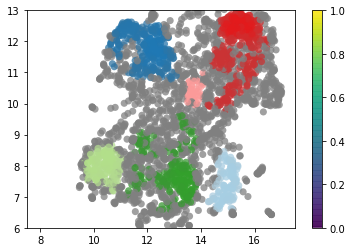

In [ ]:
import seaborn as sns
color_palette = sns.color_palette('Paired', 100) #add more colors to prevent index error in next steps 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in cluster.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, cluster.probabilities_)]
plt.scatter(*umap_embeddings.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.75)
plt.xlim(7.5, 17.5)
plt.ylim(6,13)
plt.show()

In [165]:
vectorizer = TfidfVectorizer(stop_words = 'english')
embeddings = sentence_model.encode(posts, show_progress_bar=False)
bert1 = BERTopic(hdbscan_model = cluster, language = "english", vectorizer_model = vectorizer)

In [166]:
topics, probs = bert1.fit_transform(posts,embeddings)


In [168]:
bert1.get_topic_info().head(5)

,Topic,Count,Name
0,-1,1558,-1_data_experience_work_business
1,0,362,0_data_experience_work_position
2,1,354,1_business_data_experience_requirements
3,2,194,2_data_business_experience_work
4,3,184,3_data_business_experience_work


In [169]:
bert1.visualize_heatmap()

As we can see form above the topics did not separate as well as I would have like. In the future I will spend more time on preoprocessing and creating customized transformers. 

In [185]:
bert1.visualize_barchart()

As can be seen from above there is a lot of work to be done with the top modeling. At a later date I will not allow words that are very common like (data, experience, required, and work).

Here is a great link that helped with understanding UMAP:
https://umap-learn.readthedocs.io/en/latest/parameters.html


# Conclusion

I was extremely naive with my initial scope of the project. Trying to create method to accurately classify new job postings was insane. I probably spent 50+ hours before giving up on this. After giving up, I tried to just classify on labels I created myself. I once again spent hours longer tring to do this. I tried reducing the scope again to gain a good sihloutte score for topic modeling. Unfortunately, I did not have the knowledge within NLP to do the data preprocessing. Even are receiving assistance, I realized clustering documents of the size I was working with was unrealistic. I tried using HuggingFace to help with implementation with new project ideas such as using zero-shot classification. However, the run time was way to slow.

Prior to all of this taking place, I got a 14-day free trial to datbricks to try learning a new tool and gain exposure to data engineering. I however failed with this as well by pricing out of the AWS free tier.

Clustering was unsuccessful as well after many hours and I resorted to just a table of similarity metrics with 10 randomly selected documents.

There were many more failures throughout the duration of the project but I learned a very important lesson. Be okay with imperfection. I wasted countless hours going down rabbit holes that could have easily been resolved. On top of this, I did not priortize my time well. I will likely not sleep tonight since I have about 15 hours of work to do in the next 24 hours. I am glad I learned these lessons now instead of later on when it could have easily costed me my job.

I was very happy to atleast be able to graph some  noticebale differences between some of the documents with HDBSCAn. I was unfamiliar with this technique before the assignment. I was also surprised how easy the concepts of transformers, encoders, and other new concepts were to pick up. I hope to expand on this knowledge in the near future. 